#  <h1 align="center" style="font-family: 'Georgia', serif; font-size: 35px;"> Predicting Champions League Winner of the 2025-26 season

<p style ="font-family: 'Georgia', serif; font-size: 15px">
The aim of this project is to explore how data and probability can be used to forecast the outcome of the UEFA Champions League.  
By analyzing past performances and current team dynamics, the model estimates each club’s chances of winning the trophy for the 2025–26 season.  

**Author** : Wedrik-Odal Caux

7 nov 2025

#  <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 1. Library Import

In [ ]:
from collections import defaultdict
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 2. Global Parameters and External Data

In [2]:
INITIAL_ELO = 1500
K_FACTOR = 30
HOME_ADVANTAGE = 50
NUM_SIMULATIONS = 5000
CURRENT_SEASON = '2025-2026'

# --- External elo score ---
elo_externe_data = {
    'Bayern Munich': {'Elo': 1991},
    'Real Madrid': {'Elo': 1945},
    'Manchester City': {'Elo': 1986},
    'Liverpool': {'Elo': 1991},
    'Paris S-G': {'Elo': 1974},
    'Barcelona': {'Elo': 1920}, 
    'Inter': {'Elo': 1931},
    'Arsenal': {'Elo': 2046},
    'Atlético Madrid': {'Elo': 1864},
    'Chelsea': {'Elo': 1903},
    'Dortmund': {'Elo': 1843},
    'Napoli': {'Elo': 1824},
    'Tottenham': {'Elo': 1832},
    'Newcastle Utd': {'Elo': 1879},
    'Juventus': {'Elo': 1791}, 
    'Sporting CP': {'Elo': 1802}, 
    'PSV Eindhoven': {'Elo': 1786}, 
    'Leverkusen': {'Elo': 1838},
    'Qarabağ': {'Elo': 1571},
    'Galatasaray': {'Elo': 1752},
    'Atalanta': {'Elo': 1810},
    'Marseille': {'Elo': 1759},
    'Benfica': {'Elo': 1780},
    'Ajax': {'Elo': 1607},
    'Slavia Prague': {'Elo': 1670},
    'Olympiacos': {'Elo': 1580},
    'Monaco': {'Elo': 1745},
    'Club Brugge': {'Elo': 1750},
    'Eint Frankfurt': {'Elo': 1747},
    'Athletic Club': {'Elo': 1722},
    'Union SG': {'Elo': 1726},
    'Bodø/Glimt': {'Elo': 1638},
    'Villarreal': {'Elo': 1776},
    'Pafos FC': {'Elo': 1580},
    'FC Copenhagen': {'Elo': 1570},
    'Qaırat Almaty': {'Elo': 1510}
}

# <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 3. Core Elo Calculation and Functions

<p style ="font-family: 'Times New Roman', serif; font-size: 18px"> Defines the win probability calculation and how ratings change after a match result.

In [3]:
def expected_outcome(r1, r2):
    return 1 / (1 + 10 ** ((r2 - r1) / 400))

def update_elo(r1, r2, actual_score1, k_factor):
    e1 = expected_outcome(r1, r2)
    r1_new = r1 + k_factor * (actual_score1 - e1)
    r2_new = r2 + k_factor * ((1 - actual_score1) - (1 - e1))
    return r1_new, r2_new

# <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 4. Match Probability and Simulation Functions

## <h1 align="center" style="font-family: 'Times New Roman', serif; font-size: 30px;"> 4.1. Match Probability & Result Simulation

<p style ="font-family: 'Times New Roman', serif; font-size: 18px"> Calculates a team's win probability and simulates the outcome (Win/Draw/Loss) of a single match.

In [4]:
def calculate_match_probability(elo_ratings, t1, t2, is_home=True):
    elo1 = elo_ratings.get(t1, INITIAL_ELO)
    elo2 = elo_ratings.get(t2, INITIAL_ELO)
    elo1_adj = elo1 + (HOME_ADVANTAGE if is_home else 0)
    return expected_outcome(elo1_adj, elo2)

def simulate_match_outcome(p_win_t1):
    p_draw = 0.25
    p_t1_win = p_win_t1 - (p_draw/2)
    p_t2_win = (1 - p_win_t1) - (p_draw / 2)
    probabilities = [max(0, p_t1_win), p_draw, max(0, p_t2_win)]
    total = sum(probabilities)
    normalized_probs = [p / total for p in probabilities]
    return random.choices([1, 0.5, 0], weights=normalized_probs, k=1)[0]

## <h1 align="center" style="font-family: 'Times New Roman', serif; font-size: 30px;"> 4.2. Knockout & Two-Legged Tie Simulation

<p style ="font-family: 'Times New Roman', serif; font-size: 18px"> Simulates the winner of a single-match knockout tie (e.g., Final) and a two-legged tie (e.g., Play-offs).

In [5]:
def simulate_knockout_winner(elo_ratings, t1, t2):
    p1 = calculate_match_probability(elo_ratings, t1, t2, is_home=False)
    p_t1_win = p1 + (1 - p1) * 0.5
    return t1 if random.random() < p_t1_win else t2

def simulate_two_legged_tie(elo_ratings, t1, t2):
    elo1 = elo_ratings.get(t1)
    elo2 = elo_ratings.get(t2)
    p_t1_qualify = 1 / (1 + 10 ** ((elo2 - elo1) / (400 * 2)))
    return t1 if random.random() < p_t1_qualify else t2

# <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 5. Data Loading and Preprocessing

<p style ="font-family: 'Times New Roman', serif; font-size: 18px"> Functions for loading raw data, cleaning team names, and splitting matches into 'played' and 'unplayed' sets.

In [6]:
def clean_squad_name(name):
    if isinstance(name, str):
        name = re.sub(r'[^A-Za-z0-9\s\-]', '', name)
        return name.strip()
    return name

def load_data(matches_file, standings_file):
    df_matches = pd.read_csv(matches_file, sep=';')
    df_standings = pd.read_csv(standings_file, sep=';')

    df_matches.columns = df_matches.columns.str.strip()
    df_standings.columns = df_standings.columns.str.strip()

    df_matches['Home Team'] = df_matches['Home Team'].apply(clean_squad_name)
    df_matches['Away Team'] = df_matches['Away Team'].apply(clean_squad_name)
    df_standings['Squad'] = df_standings['Squad'].apply(clean_squad_name)

    df_matches['Date'] = pd.to_datetime(df_matches['Date'], errors='coerce')
    df_matches.sort_values(by='Date', inplace=True)

    df_25_26 = df_matches[df_matches['Season'].str.strip() == CURRENT_SEASON]
    matchdays_played = df_25_26[df_25_26['Home_Score'].notna()]

    if not matchdays_played.empty:
        split_date = matchdays_played['Date'].max()
        df_played = df_matches[df_matches['Date'] <= split_date].copy()
        df_unplayed_25_26 = df_25_26[df_25_26['Date'] > split_date].copy()
    else:
        df_played = df_matches[df_matches['Season'].str.strip() != CURRENT_SEASON].copy()
        df_unplayed_25_26 = df_25_26.copy()

    df_25_26_base = df_standings[df_standings['Season'].str.strip() == CURRENT_SEASON].copy()
    df_25_26_base.drop_duplicates(subset=['Squad'], keep='first', inplace=True)
    df_25_26_base.set_index('Squad', inplace=True)

    return df_played, df_unplayed_25_26, df_25_26_base

# <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 6. Elo Initialization and Merging

## <h1 align="center" style="font-family: 'Times New Roman', serif; font-size: 30px;"> 6.1. Calculate Historical Elo

<p style ="font-family: 'Times New Roman', serif; font-size: 18px"> Calculates current ratings based solely on past match results.

In [7]:
def calculate_initial_elos(df_played):
    elo_ratings = defaultdict(lambda: INITIAL_ELO)
    for _, row in df_played.iterrows():
        h, a = row['Home Team'], row['Away Team']
        hs, as_ = row['Home_Score'], row['Away_Score']
        if pd.isna(hs) or pd.isna(as_):
            continue
        home_elo = elo_ratings[h]
        away_elo = elo_ratings[a]
        actual_score_home = 1 if hs > as_ else (0.5 if hs == as_ else 0)
        h_new, a_new = update_elo(home_elo, away_elo, actual_score_home, K_FACTOR)
        elo_ratings[h], elo_ratings[a] = h_new, a_new
    return elo_ratings

## <h1 align="center" style="font-family: 'Times New Roman', serif; font-size: 30px;"> 6.2. Merge with External Data

<p style ="font-family: 'Times New Roman', serif; font-size: 18px"> Blends the historically calculated Elo with the provided external expert Elo ratings.

In [8]:
def merge_with_external_elos(elo_ratings):
    for team, values in elo_externe_data.items():
        if team in elo_ratings:
            elo_ratings[team] = 0.7 * values['Elo'] + 0.3 * elo_ratings[team]
        else:
            elo_ratings[team] = values['Elo']
    return elo_ratings

# <h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 7. Full Season Simulation Logic

<p style ="font-family: 'Times New Roman', serif; font-size: 18px"> The comprehensive function that executes a single run of the UCL season from start to finish.

In [9]:
def simulate_ucl_season(df_unplayed_matches, elo_ratings_initial, df_25_26_base):
    sim_elos = elo_ratings_initial.copy()
    standings = df_25_26_base.reset_index()[['Squad', 'Pts', 'GD', 'GF']].copy()
    standings.set_index('Squad', inplace=True)
    standings = standings.astype(float)

    for _, row in df_unplayed_matches.iterrows():
        h, a = row['Home Team'], row['Away Team']
        if h not in standings.index or a not in standings.index:
            continue
        p_home_win = calculate_match_probability(sim_elos, h, a, is_home=True)
        outcome = simulate_match_outcome(p_home_win)
        if outcome == 1:
            standings.loc[h, 'Pts'] += 3
        elif outcome == 0.5:
            standings.loc[h, 'Pts'] += 1
            standings.loc[a, 'Pts'] += 1
        else:
            standings.loc[a, 'Pts'] += 3
        h_new, a_new = update_elo(sim_elos[h], sim_elos[a], outcome, K_FACTOR)
        sim_elos[h], sim_elos[a] = h_new, a_new

    final_rankings = standings.sort_values(by=['Pts', 'GD', 'GF'], ascending=False)
    teams = final_rankings.index.tolist()
    if len(teams) < 36:
        return teams[0]
    qualified_direct = teams[:8]
    playoff_teams = teams[8:24]
    playoff_winners = []
    if len(playoff_teams) == 16:
        for i in range(8):
            t1, t2 = playoff_teams[i], playoff_teams[15 - i]
            winner = simulate_two_legged_tie(sim_elos, t1, t2)
            playoff_winners.append(winner)
    else:
        return teams[0]
    r16_teams = qualified_direct + playoff_winners
    random.shuffle(r16_teams)
    qf = [simulate_knockout_winner(sim_elos, r16_teams[i], r16_teams[i + 1]) for i in range(0, 16, 2)]
    sf = [simulate_knockout_winner(sim_elos, qf[i], qf[i + 1]) for i in range(0, 8, 2)]
    f = [simulate_knockout_winner(sim_elos, sf[i], sf[i + 1]) for i in range(0, 4, 2)]
    champ = simulate_knockout_winner(sim_elos, f[0], f[1])
    return champ

<h1 style="font-family: 'Times New Roman', serif; font-size: 35px;">

<h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 8. Main Execution

In [10]:
def main():
    df_played, df_unplayed_25_26, df_25_26_base = load_data(
        'champions_league_total_cleaned.csv', 
        'fbref-total-UCL_cleaned.csv'
    )
    elo_ratings_initial = calculate_initial_elos(df_played)
    elo_ratings_final = merge_with_external_elos(elo_ratings_initial)
    winners_count = defaultdict(int)
    
    for i in range(NUM_SIMULATIONS):
        winner = simulate_ucl_season(df_unplayed_25_26, elo_ratings_final, df_25_26_base)
        winners_count[winner] += 1
        
    df_results = pd.DataFrame(winners_count.items(), columns=['Team', 'Wins'])
    df_results['Win_Probability'] = (df_results['Wins'] / df_results['Wins'].sum()) * 100
    df_results.sort_values(by='Win_Probability', ascending=False, inplace=True)
    
    output_filename = 'ucl_2025_2026_final_prediction.csv'
    df_results.to_csv(output_filename, index=False)
    print("Top 10 winning probability :")
    print(df_results.head(10))

if __name__ == '__main__':
    main()

Top 10 winning probability :
               Team  Wins  Win_Probability
0           Arsenal   566            11.32
6     Bayern Munich   502            10.04
4   Manchester City   458             9.16
14        Paris S-G   444             8.88
1         Liverpool   440             8.80
11      Real Madrid   393             7.86
10            Inter   380             7.60
18        Barcelona   272             5.44
2           Chelsea   260             5.20
8          Dortmund   165             3.30


<h1 style="font-family: 'Times New Roman', serif; font-size: 35px;"> 9. Prediction Representation

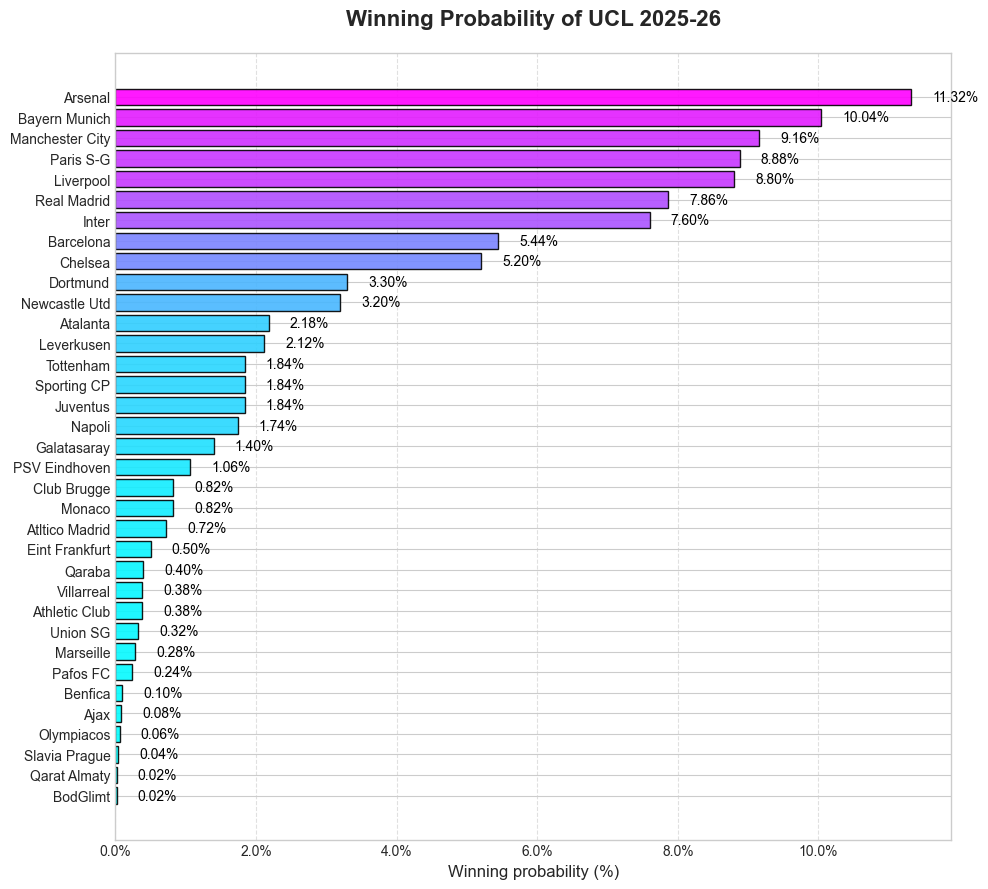

In [11]:
df = pd.read_csv("ucl_2025_2026_final_prediction.csv")

df.columns = [c.strip() for c in df.columns]
if 'Team' not in df.columns:
    df.rename(columns={df.columns[0]: 'Team'}, inplace=True)
if 'Win_Probability' not in df.columns:
    df.rename(columns={df.columns[-1]: 'Win_Probability'}, inplace=True)

df['Team'] = df['Team'].astype(str).str.strip()

df = df.sort_values('Win_Probability', ascending=True)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 9))

colors = plt.cm.cool(df['Win_Probability'] / df['Win_Probability'].max())

bars = ax.barh(df['Team'], df['Win_Probability'], color=colors, edgecolor='black', alpha=0.9)

for bar, prob in zip(bars, df['Win_Probability']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f"{prob:.2f}%", va='center', fontsize=10, color='black')

ax.set_title("Winning Probability of UCL 2025-26", fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Winning probability (%)", fontsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(100))

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()